# 👉 What is PyCaret?

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that speeds up the experiment cycle exponentially and makes you more productive.

In comparison with the other open-source machine learning libraries, PyCaret is an alternate low-code library that can be used to replace hundreds of lines of code with few words only. This makes experiments exponentially fast and efficient. PyCaret is essentially a Python wrapper around several machine learning libraries and frameworks such as scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray, and many more.

The design and simplicity of PyCaret is inspired by the emerging role of citizen data scientists, a term first used by Gartner. Citizen Data Scientists are power users who can perform both simple and moderately sophisticated analytical tasks that would previously have required more expertise. Seasoned data scientists are often difficult to find and expensive to hire but citizen data scientists can be an effective way to mitigate this gap and address data-related challenges in the business setting.

Official Website: https://www.pycaret.org
Documentation: https://pycaret.readthedocs.io/en/latest/

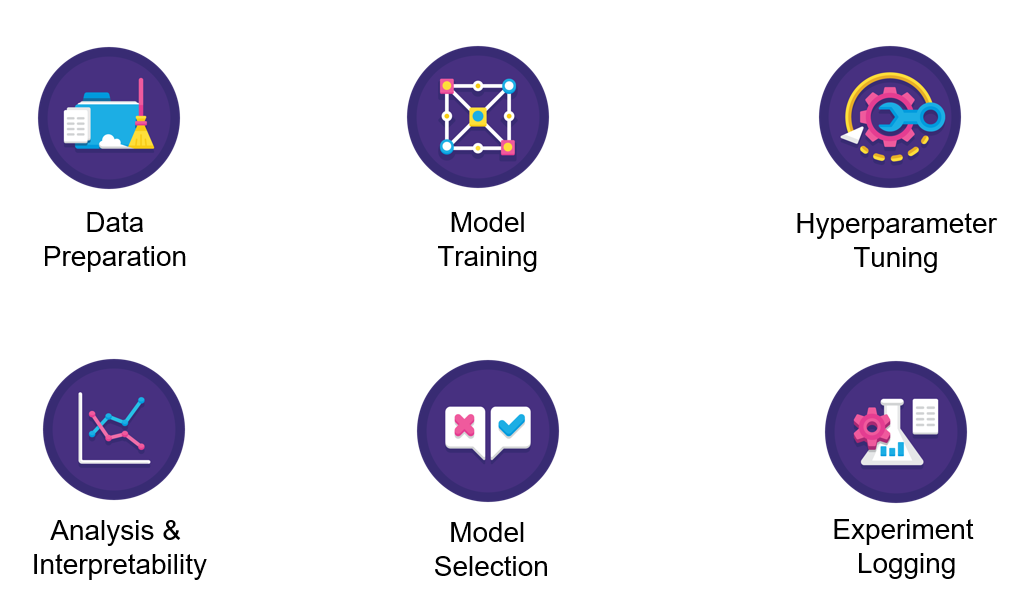

# 👉 Install PyCaret
Installing PyCaret is very easy and takes only a few minutes. We strongly recommend using a virtual environment to avoid potential conflicts with other libraries. PyCaret's default installation is a slim version of pycaret that only installs hard dependencies that are listed in [requirements.txt](https://github.com/pycaret/pycaret/blob/master/requirements.txt). To install the default version:

- `pip install pycaret`

When you install the full version of pycaret, all the optional dependencies as listed [here](https://github.com/pycaret/pycaret/blob/master/requirements-optional.txt) are also installed.To install version:

- `pip install pycaret[full]`

# 👉Dataset

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('C:/Users/moezs/pycaret-demo-mlflow/store_demand.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

In [2]:
data.shape

(913000, 4)

In [3]:
# select 1 store and 10 item only for demo-purpose
data = data[(data['store'] <= 1) & (data['item'] <= 5)]

In [4]:
# extract features
data['store'] = ['store_' + str(i) for i in data['store']]
data['item'] = ['item_' + str(i) for i in data['item']]
data['time_series'] = data[['store', 'item']].apply(lambda x: '_'.join(x), axis=1)
data.drop(['store', 'item'], axis=1, inplace=True)

data['month'] = [i.month for i in data['date']]
data['year'] = [i.year for i in data['date']]
data['day_of_week'] = [i.dayofweek for i in data['date']]
data['day_of_year'] = [i.dayofyear for i in data['date']]

data.head()

date  sales     time_series  month  year  day_of_week  day_of_year
0 2013-01-01     13  store_1_item_1      1  2013            1            1
1 2013-01-02     11  store_1_item_1      1  2013            2            2
2 2013-01-03     14  store_1_item_1      1  2013            3            3
3 2013-01-04     13  store_1_item_1      1  2013            4            4
4 2013-01-05     10  store_1_item_1      1  2013            5            5

In [5]:
data['time_series'].nunique()

5

In [6]:
import plotly.express as px

for i in data['time_series'].unique()[:3]:
    subset = data[data['time_series'] == i]
    subset['moving_average'] = subset['sales'].rolling(30).mean()
    fig = px.line(subset, x="date", y=["sales","moving_average"], title = i, template = 'plotly_dark')
    fig.show()

C:\Users\moezs\Anaconda3\envs\pycaret-dev\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 👉 Training Loop

In [7]:
%%time

from tqdm import tqdm

from pycaret.regression import *

all_ts = data['time_series'].unique()

all_results = []
final_model = {}


for i in tqdm(all_ts):
    
    df_subset = data[data['time_series'] == i]
    
    s = setup(df_subset, target = 'sales', session_id = 123, train_size = 0.95,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              ignore_features = ['date', 'time_series'],
              numeric_features = ['day_of_year', 'year'],
              categorical_features = ['month', 'day_of_week'],
              silent = True, verbose = False,
              log_experiment = True, experiment_name = i, log_plots = True)
        
    best_model = compare_models(sort = 'MAE', verbose=False)
    
    p = pull().iloc[0:1]
    p['time_series'] = str(i)
    all_results.append(p)
    
    f = finalize_model(best_model)
    
    final_model[i] = f
    
    save_model(f, model_name='trained_models/' + str(i), verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.64s/it]

Wall time: 2min 35s


In [8]:
concat_results = pd.concat(all_results,axis=0)
concat_results.head()

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE  \
br        Bayesian Ridge  3.7656  22.3829  4.7245  0.4782  0.2346  0.2114   
ridge   Ridge Regression  6.8092  72.5645  8.5126  0.6507  0.1578  0.1339   
lr     Linear Regression  4.9629  40.1364  6.3347  0.5717  0.1836  0.1550   
lr     Linear Regression  3.9444  23.5025  4.8445  0.4309  0.2335  0.2117   
ridge   Ridge Regression  3.3744  18.1570  4.2609  0.3978  0.2563  0.2319   

       TT (Sec)     time_series  
br       0.0267  store_1_item_1  
ridge    0.0167  store_1_item_2  
lr       0.0133  store_1_item_3  
lr       0.0167  store_1_item_4  
ridge    0.0133  store_1_item_5

In [9]:
!mlflow ui

^C


# Create Future DataFrame

In [10]:
all_dates = pd.date_range(start='2013-01-01', end = '2019-12-31', freq = 'D')

score_df = pd.DataFrame()
score_df['date'] = all_dates

score_df['month'] = [i.month for i in score_df['date']]
score_df['year'] = [i.year for i in score_df['date']]
score_df['day_of_week'] = [i.dayofweek for i in score_df['date']]
score_df['day_of_year'] = [i.dayofyear for i in score_df['date']]

score_df.head()

date  month  year  day_of_week  day_of_year
0 2013-01-01      1  2013            1            1
1 2013-01-02      1  2013            2            2
2 2013-01-03      1  2013            3            3
3 2013-01-04      1  2013            4            4
4 2013-01-05      1  2013            5            5

In [11]:
from pycaret.regression import load_model, predict_model

all_score_df = []
loaded_models = {}

for i in tqdm(data['time_series'].unique()):
    l = load_model('trained_models/' + str(i), verbose=False)
    loaded_models[i] = l
    p = predict_model(l, data=score_df)
    p['time_series'] = i
    all_score_df.append(p)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


In [12]:
concat_df = pd.concat(all_score_df, axis=0)
concat_df.head()

date  month  year  day_of_week  day_of_year      Label     time_series
0 2013-01-01      1  2013            1            1   8.927565  store_1_item_1
1 2013-01-02      1  2013            2            2   9.515175  store_1_item_1
2 2013-01-03      1  2013            3            3  10.213244  store_1_item_1
3 2013-01-04      1  2013            4            4  11.780002  store_1_item_1
4 2013-01-05      1  2013            5            5  13.710251  store_1_item_1

In [13]:
final_df = pd.merge(concat_df, data, how = 'left', left_on=['date', 'time_series'], right_on = ['date', 'time_series'])
final_df.head()

date  month_x  year_x  day_of_week_x  day_of_year_x      Label  \
0 2013-01-01        1    2013              1              1   8.927565   
1 2013-01-02        1    2013              2              2   9.515175   
2 2013-01-03        1    2013              3              3  10.213244   
3 2013-01-04        1    2013              4              4  11.780002   
4 2013-01-05        1    2013              5              5  13.710251   

      time_series  sales  month_y  year_y  day_of_week_y  day_of_year_y  
0  store_1_item_1   13.0      1.0  2013.0            1.0            1.0  
1  store_1_item_1   11.0      1.0  2013.0            2.0            2.0  
2  store_1_item_1   14.0      1.0  2013.0            3.0            3.0  
3  store_1_item_1   13.0      1.0  2013.0            4.0            4.0  
4  store_1_item_1   10.0      1.0  2013.0            5.0            5.0

In [14]:
final_df.set_index('date', drop=True, inplace=True)

all_subs = []

for i in final_df['time_series'].unique():
    sub = final_df[final_df['time_series'] == i]
    sub = sub[['Label','sales']]
    sub = sub.resample('M').sum()
    sub['time_series'] = i
    all_subs.append(sub)
    
concat_sub = pd.concat(all_subs, axis=0)
concat_sub['sales'] = concat_sub['sales'].replace(0,np.nan)

concat_sub.head()

Label  sales     time_series
date                                         
2013-01-31  334.185181  328.0  store_1_item_1
2013-02-28  332.120509  322.0  store_1_item_1
2013-03-31  465.129162  477.0  store_1_item_1
2013-04-30  531.820731  522.0  store_1_item_1
2013-05-31  599.933148  531.0  store_1_item_1

In [15]:
for i in concat_sub['time_series'].unique()[:5]:
    sub_df = concat_sub[concat_sub['time_series'] == i]
    
    import plotly.express as px
    fig = px.line(sub_df, x=sub_df.index, y=['sales', 'Label'], title=i, template = 'plotly_dark')
    fig.show()

## THE END